In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from obp.dataset import OpenBanditDataset

In [4]:
# --- Load OBD (Random / all as example) ---
ds = OpenBanditDataset(behavior_policy="random", campaign="all")
bf = ds.obtain_batch_bandit_feedback()

print("bandit_feedback keys:", bf.keys())
print(f"Rounds: {bf['n_rounds']:,} | n_actions: {bf['n_actions']} | len_list: {ds.len_list}")

# Build a DataFrame for convenience
df = pd.DataFrame({
    "action": bf["action"],
    "position": bf["position"],
    "reward": bf["reward"],
    "pscore": bf["pscore"],
})


INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


bandit_feedback keys: dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])
Rounds: 10,000 | n_actions: 80 | len_list: 3


# --- 1. CTR by slot ---


CTR by slot (0-based positions):
 position
0    0.003913
1    0.004103
2    0.003368
Name: reward, dtype: float64


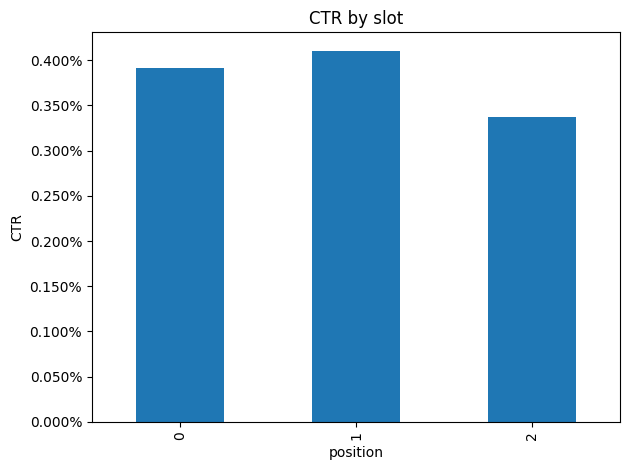

In [9]:
ctr_by_slot = df.groupby("position")["reward"].mean()
print("\nCTR by slot (0-based positions):\n", ctr_by_slot)

ax = ctr_by_slot.plot(kind="bar", title="CTR by slot", ylabel="CTR")
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.tight_layout()
plt.savefig("../results/fig_ctr_by_slot_random_all.png", dpi=160)
plt.show()


# --- 2. Propensity histogram ---

In [12]:
df.head()

,action,position,reward,pscore
0,14,2,0,0.0125
1,14,2,0,0.0125
2,27,2,0,0.0125
3,48,1,0,0.0125
4,36,1,0,0.0125


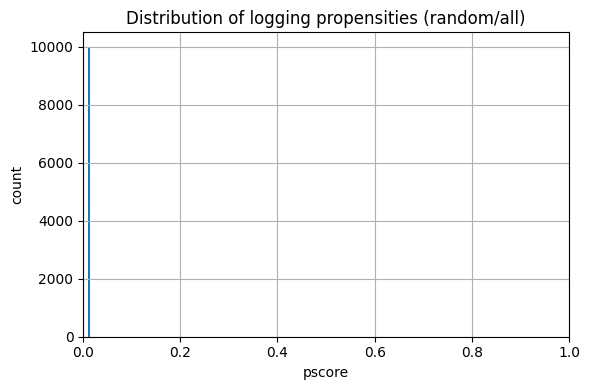

Propensity range: min=0.012500, max=0.012500


In [11]:
# --- 2. Propensity histogram (0–1 scale) ---
plt.figure(figsize=(6,4))
pd.Series(df["pscore"]).hist(bins=200, range=(0,1))
plt.title("Distribution of logging propensities (random/all)")
plt.xlabel("pscore")
plt.ylabel("count")
plt.xlim(0, 1)   # ensure axis covers full 0–1
plt.tight_layout()
plt.savefig("../results/fig_pscore_hist_random_all.png", dpi=160)
plt.show()

print(f"Propensity range: min={df['pscore'].min():.6f}, max={df['pscore'].max():.6f}")

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.
INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


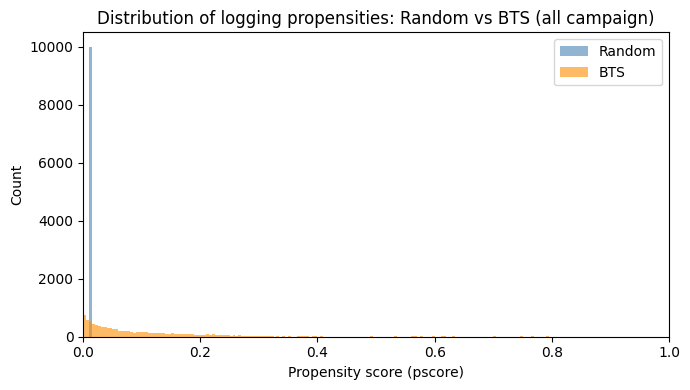

Random policy pscore range: 0.0125 - 0.0125
BTS policy pscore range: 4.5e-05 - 0.95424


In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from obp.dataset import OpenBanditDataset

# Load Random / all
ds_rand = OpenBanditDataset(behavior_policy="random", campaign="all")
bf_rand = ds_rand.obtain_batch_bandit_feedback()
df_rand = pd.DataFrame({"pscore": bf_rand["pscore"]})

# Load BTS / all
ds_bts = OpenBanditDataset(behavior_policy="bts", campaign="all")
bf_bts = ds_bts.obtain_batch_bandit_feedback()
df_bts = pd.DataFrame({"pscore": bf_bts["pscore"]})

# Plot overlay
plt.figure(figsize=(7,4))
plt.hist(df_rand["pscore"], bins=200, range=(0,1), alpha=0.6, label="Random", color="steelblue")
plt.hist(df_bts["pscore"], bins=200, range=(0,1), alpha=0.6, label="BTS", color="darkorange")
plt.xlim(0, 1)
plt.xlabel("Propensity score (pscore)")
plt.ylabel("Count")
plt.title("Distribution of logging propensities: Random vs BTS (all campaign)")
plt.legend()
plt.tight_layout()
plt.savefig("../results/fig_pscore_hist_random_vs_bts.png", dpi=160)
plt.show()

print("Random policy pscore range:", df_rand["pscore"].min(), "-", df_rand["pscore"].max())
print("BTS policy pscore range:", df_bts["pscore"].min(), "-", df_bts["pscore"].max())

BTS is a contextual bandit that uses:
* User context (20-dim vector in OBD),
* Item context (4-dim vector),
* A logistic regression model that estimates click probability $\hat{p}(a|x)$.
* Thompson Sampling samples model parameters from their posterior (around logistic regression weights) and then chooses items with probabilities proportional to the sampled $\hat{p}(a|x)$.
So, unlike Random, the probabilities depend on the context (which user, which features) and model confidence.
```

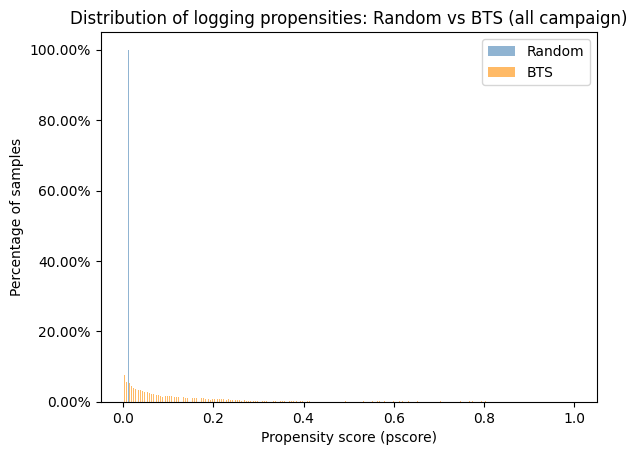

In [19]:
plt.hist([df_rand["pscore"], df_bts["pscore"]],
         bins=200, range=(0,1), alpha=0.6,
         label=["Random","BTS"], color=["steelblue","darkorange"],
         density=False)

plt.gca().yaxis.set_major_formatter(
    plt.matplotlib.ticker.PercentFormatter(xmax=len(df_rand), decimals=2)
)
plt.ylabel("Percentage of samples")
plt.xlabel("Propensity score (pscore)")
plt.title("Distribution of logging propensities: Random vs BTS (all campaign)")
plt.legend()